# MIA vs Overfitting

In this notebook we will study the effect of overfitting in MIA's performance, given a CNN model, CIFAR-10 dataset and a MIA framework that will perfrom the attacks for us.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import regularizers

# for image interpolation
import scipy.ndimage.interpolation as interpolation

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from mia_v2.attack_model import *
from mia_v2.label_only import *
from mia_v2.shadow_models import *
from mia_v2.utilities import *
from mia_v2.wrappers import ConfidenceVectorAttack, LabelOnlyAttack

from tqdm import tqdm
import sys
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
def f_target(X_train, y_train, epochs=100):
  """
  Returns a trained target model, if test data are specified we will evaluate the model and print its accuracy
  """
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='tanh'))


  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.SGD(learning_rate=0.001, decay=1e-7)

  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  history = model.fit(X_train, y_train, 
                      epochs=epochs, 
                      validation_split=0.2
                      )
  return model, history

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [4]:
print(f"We have {len(train_images)} train instances and {len(test_images)} test instances.")

We have 50000 train instances and 10000 test instances.


Let us give the attacker 10000 data points and let the rest of them be training-evaluation-testing datapoints for the target model.

In [5]:
attacker_images, attacker_labels = (test_images, test_labels)
N_SHADOWS = 10
D_SHADOW= attacker_images.shape[0]//N_SHADOWS

In [10]:
def f_shadow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.SGD(learning_rate=0.001, decay=1e-7)
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

In [11]:
attack = ConfidenceVectorAttack(None, (train_images, train_labels), 
                                  (attacker_images, attacker_labels), shadow_creator=f_shadow, attack_model_creator=cifar_10_f_attack_builder,
                                n_shadows=N_SHADOWS, D_shadow_size=D_SHADOW, verbose=True)
attack.perform_attack()

Epoch 1/25
21/21 [==============================] - 1s 20ms/step - loss: 7.9650 - accuracy: 0.1030 - val_loss: 2.5664 - val_accuracy: 0.1606
Epoch 2/25
21/21 [==============================] - 0s 11ms/step - loss: 2.4043 - accuracy: 0.1507 - val_loss: 2.3899 - val_accuracy: 0.1606
Epoch 3/25
21/21 [==============================] - 0s 12ms/step - loss: 2.2352 - accuracy: 0.2164 - val_loss: 2.3166 - val_accuracy: 0.1576
Epoch 4/25
21/21 [==============================] - 0s 13ms/step - loss: 2.1301 - accuracy: 0.2627 - val_loss: 2.2466 - val_accuracy: 0.2333
Epoch 5/25
21/21 [==============================] - 0s 12ms/step - loss: 2.0557 - accuracy: 0.2627 - val_loss: 2.2911 - val_accuracy: 0.1879
Epoch 6/25
21/21 [==============================] - 0s 11ms/step - loss: 1.9689 - accuracy: 0.3149 - val_loss: 2.1861 - val_accuracy: 0.2212
Epoch 7/25
21/21 [==============================] - 0s 11ms/step - loss: 1.8644 - accuracy: 0.3388 - val_loss: 2.2640 - val_accuracy: 0.2152
Epoch 8/25
21

Epoch 1/100
50/50 [==============================] - 1s 14ms/step - loss: 2.2898 - accuracy: 0.1481 - val_loss: 2.2117 - val_accuracy: 0.1625
Epoch 2/100
50/50 [==============================] - 0s 9ms/step - loss: 2.1480 - accuracy: 0.2163 - val_loss: 2.1492 - val_accuracy: 0.2150
Epoch 3/100
50/50 [==============================] - 0s 9ms/step - loss: 2.0583 - accuracy: 0.2450 - val_loss: 2.0677 - val_accuracy: 0.2525
Epoch 4/100
50/50 [==============================] - 1s 13ms/step - loss: 2.0081 - accuracy: 0.2637 - val_loss: 2.0439 - val_accuracy: 0.2650
Epoch 5/100
50/50 [==============================] - 0s 9ms/step - loss: 1.9639 - accuracy: 0.2788 - val_loss: 1.9995 - val_accuracy: 0.2850
Epoch 6/100
50/50 [==============================] - 0s 9ms/step - loss: 1.9062 - accuracy: 0.3231 - val_loss: 1.9573 - val_accuracy: 0.2775
Epoch 7/100
50/50 [==============================] - 0s 9ms/step - loss: 1.8714 - accuracy: 0.3269 - val_loss: 1.9951 - val_accuracy: 0.3000
Epoch 8/100

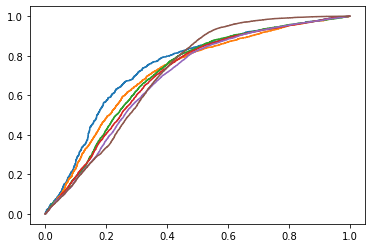

In [12]:
scores = []
history = []

for dataset_size in [2000, 2500, 5000, 7500, 10000, 20000]:
  X_train, _, y_train, _ = train_test_split(train_images, train_labels, train_size=dataset_size)
  target_model, h = f_target(X_train, y_train, epochs=100)
  history.append(h)

  attack.target_model = target_model
  attack.target_dataset = X_train, y_train
  _score = attack.evaluate_attack()
  scores.append(_score)



In [15]:
epochs = [2000, 2500, 5000, 7500, 10000, 20000]

Text(0, 0.5, 'AUC Score')

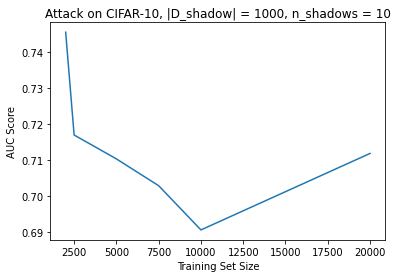

In [21]:
auc_scores = [items[1] for items in scores]

plt.plot(epochs, auc_scores)
plt.title('Attack on CIFAR-10, |D_shadow| = 1000, n_shadows = 10')
plt.xlabel('Training Set Size')
plt.ylabel('AUC Score')

Text(0, 0.5, 'Recall Score')

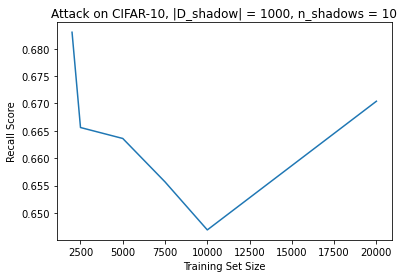

In [22]:
recall_scores = [items[0]['macro avg']['recall'] for items in scores]

plt.plot(epochs, recall_scores)
plt.title('Attack on CIFAR-10, |D_shadow| = 1000, n_shadows = 10')
plt.xlabel('Training Set Size')
plt.ylabel('Recall Score')

Text(0, 0.5, 'Precision Score')

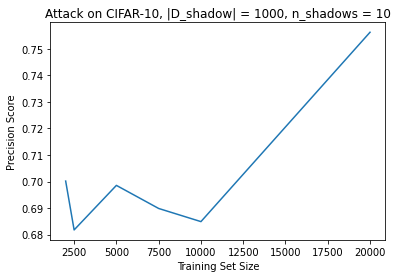

In [23]:
precision_scores = [items[0]['macro avg']['precision'] for items in scores]

plt.plot(epochs, precision_scores)

plt.title('Attack on CIFAR-10, |D_shadow| = 1000, n_shadows = 10')
plt.xlabel('Training Set Size')
plt.ylabel('Precision Score')

Text(0, 0.5, 'Accuracy Score')

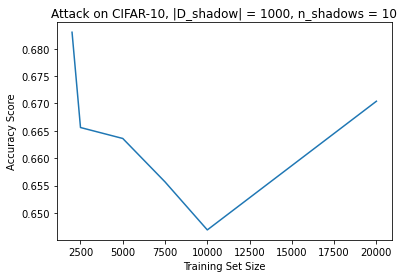

In [24]:
accuracy_scores = [items[0]['accuracy'] for items in scores]

plt.plot(epochs, accuracy_scores)

plt.title('Attack on CIFAR-10, |D_shadow| = 1000, n_shadows = 10')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')